In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib.imports import *
from lib.utils import *
from lib.modules import *
from lib.functions import *
from ipynb.fs.defs.losses import *

In [3]:
G_list, data_list = load_processed_data(G_list_file='G_list_1.pickle', 
                                        data_list_file='data_list_1.pickle')

In [199]:
loader = DataLoader(data_list[:10000], batch_size=8, shuffle=True)
batch = next(iter(loader))
batch_pos = batch.x
batch_list = batch.to_data_list()
data = data_list[0]
data_pos = data.x

In [200]:
def get_adj(batch, reverse=False, value=1):
    device = batch.x.device
    adj = torch.zeros(batch.num_nodes, batch.num_nodes).to(device)
    adj[tuple(batch.edge_index)] = 1
    return (1 - adj if reverse else adj) * value

# Hack: will fail for non-complete graphs
def get_complete_adj(batch):
    return get_adj(batch) + np.eye(batch.num_nodes)

def get_shorted_path_adj(batch):
    adj =  get_adj(batch, reverse=True, value=np.inf)
    adj[tuple(batch.edge_index)] = batch.edge_attr[:, 0]
    return adj

def get_edge_length_adj(batch, pos):
    adj =  get_adj(batch, reverse=True, value=np.inf)
    adj[tuple(batch.edge_index)] = (pos[batch.edge_index[0]] - pos[batch.edge_index[1]]).norm(dim=1)
    return adj

def get_num_nodes_adj(batch):
    adj = get_complete_adj(batch)
    adj *= adj.sum(dim=1, keepdim=True)
    return adj

def graph_wise_normalize(batch, mat):
    adj = get_complete_adj(batch)
    sum_mat = adj * mat.sum(dim=0, keepdim=True)
    sum_mat = adj * sum_mat.sum(dim=1, keepdim=True)
    return mat / (sum_mat + 1e-5) 

In [206]:
class TSNELoss(nn.Module):
    def __init__(self, sigma=1):
        super().__init__()
        self.sigma = sigma
        
    def forward(self, node_pos, batch):
        p = get_shorted_path_adj(batch).div(-2 * sigma**2).exp()
        p /= p.sum(dim=1, keepdim=True)
        p = (p + p.T) / 2 / get_num_nodes_adj(batch)
        p = p[tuple(batch.edge_index)]
        q = get_edge_length_adj(batch, node_pos).square()
        q = 1 / (1 + q)
        q = graph_wise_normalize(batch, q)
        q = q[tuple(batch.edge_index)]
        kl = (p.log() - q.log()).mul(p).sum()
        return kl.div(batch.num_graphs)

In [207]:
class RescaledTSNELoss(nn.Module):
    def __init__(self, sigma=1):
        super().__init__()
        self.sigma = sigma
        
    def forward(self, node_pos, batch):
        num_nodes_adj = get_num_nodes_adj(batch)
        num_nodes = num_nodes_adj[tuple(batch.edge_index)]
        p = get_shorted_path_adj(batch).div(-2 * sigma**2).exp()
        p /= p.sum(dim=1, keepdim=True)
        p = (p + p.T) / 2 / num_nodes_adj
        p = p[tuple(batch.edge_index)]
        q = get_edge_length_adj(batch, node_pos).square()
        q = 1 / (1 + q)
        q = graph_wise_normalize(batch, q)
        q = q[tuple(batch.edge_index)]
        return (p.log().sub(q.log()).mul(p)
                 .mul(num_nodes)
                 .mul(num_nodes - 1)
                 .sum()
                 .div(batch.num_graphs))

In [34]:
def reso_score_by_idx(idx):
    data = data_list[idx]
    G = G_list[idx]
    stress_criterion = StressLoss()
    pos = get_ground_truth(data,G)
    scaled_stress = stress_criterion(pos, Batch.from_data_list([data]))
    graph_vis(G, pos)
    return get_resolution_score(*get_radians(pos, data, 
                                             return_node_degrees=True,
                                             return_node_indices=True)),scaled_stress

(tensor(0.7232), tensor(86.5318))

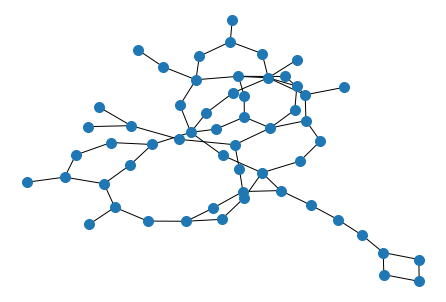

In [36]:
reso_score_by_idx(10260)

In [41]:
convert_to_padded_batch(batch_pos, batch).sum(dim=[1,2])

tensor([11.8241, 13.3162,  6.7794, 12.5557,  6.9331,  8.9142, 11.3773,  6.9331])

In [84]:
EdgeLengthVarianceLoss()(batch_pos, batch)

tensor(417.8878)

In [92]:
get_full_edges(batch_pos, batch)[0].shape

torch.Size([19204, 2])

In [10]:
RatioAngularLoss()(pos, batch) / RescaledRatioAngularLoss()(pos, batch) * 2

tensor(0.1324)

In [5]:
energy_loss = EnergyLossVectorized()
ring_loss = RingLoss()
angular_loss = AngularResolutionLoss()
angular_l2_loss = AngularResolutionL2Loss()
angular_ratio_loss = AngularResolutionRatioLoss()
angular_sine_loss = AngularResolutionSineLoss()

In [6]:
energy_loss(pos, batch)

tensor(2973.1755)

In [7]:
ring_loss(pos, batch)

tensor(16893.0254)

In [8]:
angular_loss(pos, batch)

tensor(533.0134)

In [8]:
angular_l2_loss(pos, batch)

tensor(9.8881)

In [9]:
angular_ratio_loss(pos, batch)

tensor(26936.1445)

In [10]:
angular_sine_loss(pos, batch)

tensor(234.2465)

In [14]:
[(i, j) for i in range(5) for j in range(5) if i != j]

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 3),
 (2, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 4),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3)]

In [3]:
a = torch.tensor([[1,1]]).dot(torch.tensor([[1,1]]))

RuntimeError: 1D tensors expected, got 2D, 2D tensors at /opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/TH/generic/THTensorEvenMoreMath.cpp:733

In [6]:
np.sign(-np.inf)

-1.0

In [8]:
F.normalize(torch.tensor([[0.,0.]]))

tensor([[0., 0.]])

In [17]:
a = torch.zeros(5087, 2)

a / (a.norm(dim=1).unsqueeze(dim=1) + 1e-5)

# torch_normalize(a)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])

In [12]:
real_edges = get_real_edges(batch)
angles = get_counter_clockwise_sorted_angle_vertices(real_edges, pos)
u, v1, v2 = angles[:, 0], angles[:, 1], angles[:, 2]
get_node_degrees_by_indices(real_edges, u)

tensor([2, 2, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4,
        4, 4, 4, 2, 2, 2, 2, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 2, 2, 3, 3, 3, 2, 2,
        2, 2, 3, 3, 3, 2, 2, 5, 5, 5, 5, 5, 3, 3, 3, 2, 2, 4, 4, 4, 4, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2,
        2, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2,
        2, 2, 3, 3, 3, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3,
        3, 3, 2, 2, 2, 2, 4, 4, 4, 4, 2, 2, 5, 5, 5, 5, 5, 2, 2, 3, 3, 3, 3, 3,
        3, 2, 2, 3, 3, 3, 2, 2, 2, 2, 5, 5, 5, 5, 5, 2, 2, 5, 5, 5, 5, 5, 3, 3,
        3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 2, 2, 6, 6, 6, 6, 6,
        6, 2, 2, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 3, 3, 3, 2, 2, 3, 3, 3, 2, 2, 2,
        2, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 4, 4, 4, 4, 5, 5, 5, 5, 5,
        2, 2, 4, 4, 4, 4, 2, 2, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 2, 2, 2, 2, 3, 3,
        3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [19]:
data = data_list[0]
theta,degree,u = get_theta_angles_and_node_degrees(data.x, data,return_u=True)
sorted_idx = sorted(np.arange(len(u)), key=lambda e: (u[e], theta[e]))
# sorted_v = v[sorted_idx]
# # get start index for each u
idx = np.unique(u, return_index=True)[1]

In [22]:
u[sorted_idx]

array([ 0,  0,  0,  0,  2,  2,  3,  3,  3,  3,  4,  4,  6,  6,  8,  8,  8,
        9,  9,  9, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14,
       15, 15, 15, 15, 15])

In [23]:
theta[sorted_idx]

tensor([0.2882, 1.5693, 1.8133, 2.6124, 0.5049, 0.5049, 0.0106, 0.3381, 0.6830,
        1.0301, 0.5110, 0.5110, 0.9955, 0.9955, 0.0998, 0.5432, 0.6426, 0.7850,
        1.0615, 1.8464, 0.0326, 0.0326, 0.0781, 1.3410, 1.4189, 0.2410, 0.4735,
        0.7143, 1.6525, 2.2210, 2.4095, 0.1980, 0.9522, 1.1501, 0.1183, 0.3945,
        0.4254, 0.7869, 1.7248])

In [42]:
idx = np.unique(u, return_index=True)
idx

(array([ 0,  2,  3,  4,  6,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([ 0,  4,  6, 10, 12, 14, 17, 20, 22, 25, 28, 31, 34]))

In [37]:
degree

tensor([4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5])

In [40]:
degree[idx]

tensor([4, 2, 4, 2, 2, 3, 3, 2, 3, 3, 3, 3, 5])

In [41]:
theta[sorted_idx][idx]

tensor([0.2882, 0.5049, 0.0106, 0.5110, 0.9955, 0.0998, 0.7850, 0.0326, 0.0781,
        0.2410, 1.6525, 0.1980, 0.1183])

In [ ]:
def resolution_score(theta,degree,u):
    sorted_idx = sorted(np.arange(len(u)), key=lambda e: (u[e], theta[e]))
    u_idx = np.unique(u, return_index=True)[1]
    min_theta = theta[sorted_idx][idx].cpu()
    min_degree = degree[idx]
    return (min_theta * min_degree/(2 * np.pi)).mean().item()

In [3]:
idx = 10320
data = data_list[idx]
G = G_list[idx]
truth = torch.tensor(get_ground_truth(G))
theta,degree,u = get_theta_angles_and_node_degrees(truth, data,return_u=True)
resolution_score(theta,degree,u)

0.5052969575519529

In [ ]:
criterion =

In [13]:
theta, degrees = get_theta_angles_and_node_degrees(data_pos, data)
phi = degrees.float().pow(-1).mul(2*np.pi)
phi.sub(theta).square().sum().abs().sqrt()

tensor(9.8881)

In [18]:
phi.sub(theta)

tensor([-2.4254e-01, -1.0416e+00,  1.5163e-03,  1.2826e+00,  2.6367e+00,
         2.6367e+00,  1.5602e+00,  8.8781e-01,  1.2327e+00,  5.4068e-01,
         2.6306e+00,  2.6306e+00,  2.1461e+00,  2.1461e+00,  1.5512e+00,
         1.9946e+00,  1.4517e+00,  1.0329e+00,  1.3094e+00,  2.4795e-01,
         3.1090e+00,  3.1090e+00,  2.0162e+00,  6.7552e-01,  7.5338e-01,
         1.6209e+00,  1.8534e+00,  1.3801e+00,  4.4186e-01, -1.2664e-01,
        -3.1514e-01,  1.1422e+00,  1.8964e+00,  9.4427e-01,  8.3120e-01,
         4.6978e-01,  8.6213e-01,  1.1383e+00, -4.6815e-01])

In [22]:
phi.sub(theta).square().sum().abs()

tensor(97.7753)

In [5]:
import numpy as np
np.set_printoptions(precision=2)

In [7]:
print(np.array([10.1123]))

[10.11]


In [1]:
f'{0.0000034:.2e}'

'3.40e-06'